In [1]:
import os
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, callbacks
import tensorflow.keras.backend as K

%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU') 
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
image_width = 224
image_height = 224
num_classes = 5
histories = []

In [8]:
images_dir = "flowers-subset/"
train_data_dir = images_dir + "train/"
val_data_dir = images_dir + "val/"
test_data_dir = images_dir + "test/"

In [39]:
images_dir = "flowers-complete/"
train_data_dir = images_dir 
val_data_dir = images_dir 
test_data_dir = images_dir 

In [9]:
checkpoint_dir = "checkpoints/"
checkpoint_name = checkpoint_dir + "flora-transferLearning-{val_loss:.4f}-{val_accuracy:.4f}.hdf5"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [10]:
def create_callbacks():
    return [
        callbacks.EarlyStopping(monitor="val_accuracy", patience=10, verbose=1),

        callbacks.ModelCheckpoint(checkpoint_name, monitor="val_accuracy", 
                                  verbose=1, save_best_only=True),
    ]

my_callbacks = create_callbacks()

In [11]:
my_callbacks = create_callbacks()

In [12]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(input_shape=(image_height, image_width, 3), 
                       include_top=False, weights="imagenet", 
                       pooling=None)

In [13]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

train_datagen = ImageDataGenerator(
                    rotation_range=40,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    zoom_range=0.2,
                    channel_shift_range=0.2,
                    horizontal_flip=True,
                    fill_mode="nearest",
                    preprocessing_function=preprocess_input)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [40]:
batch_size = 64

train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=True)

val_generator = val_datagen.flow_from_directory(
                    val_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

test_generator = test_datagen.flow_from_directory(
                    test_data_dir,
                    target_size=(image_width, image_height),
                    batch_size=batch_size,
                    class_mode="categorical",
                    shuffle=False)

Found 4323 images belonging to 5 classes.
Found 4323 images belonging to 5 classes.
Found 4323 images belonging to 5 classes.


In [19]:
from tensorflow.keras import regularizers

top_model = Sequential()
top_model.add(base_model)
top_model.add(GlobalAveragePooling2D())
top_model.add(Dropout(0.7))
top_model.add(Dense(num_classes, kernel_regularizer=regularizers.l2(0.01)))
top_model.add(Activation("softmax"))

In [26]:
for layer in base_model.layers:
    layer.trainable = False

top_model.compile(loss="categorical_crossentropy",
                  optimizer=optimizers.Adam(lr=1e-2),
                  metrics=["accuracy"])    

In [27]:
histories.append(top_model.fit(train_generator, 
                              steps_per_epoch=len(train_generator),
                              epochs=60,
                              callbacks=my_callbacks,
                              validation_data=val_generator,
                              validation_steps=len(val_generator),
                              workers=8))

Epoch 1/60
1/1 [==============================] - 2s 2s/step - loss: 2.9001 - accuracy: 0.2000 - val_loss: 1.2400 - val_accuracy: 0.5600

Epoch 00001: val_accuracy improved from 0.48000 to 0.56000, saving model to checkpoints/flora-transferLearning-1.2400-0.5600.hdf5
Epoch 2/60
1/1 [==============================] - 0s 313ms/step - loss: 2.1747 - accuracy: 0.4800 - val_loss: 0.6041 - val_accuracy: 0.8000

Epoch 00002: val_accuracy improved from 0.56000 to 0.80000, saving model to checkpoints/flora-transferLearning-0.6041-0.8000.hdf5
Epoch 3/60
1/1 [==============================] - 0s 312ms/step - loss: 1.0187 - accuracy: 0.6800 - val_loss: 0.4312 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.80000 to 1.00000, saving model to checkpoints/flora-transferLearning-0.4312-1.0000.hdf5
Epoch 4/60
1/1 [==============================] - 0s 332ms/step - loss: 0.7020 - accuracy: 0.8800 - val_loss: 0.3522 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.

## Evaluate on the best model

In [41]:
from tensorflow.keras.models import load_model
model_saved_name = ""

best_model = load_model(checkpoint_dir + "flora-transferLearning-0.4312-1.0000.hdf5")

In [42]:
best_model.evaluate_generator(test_generator, steps=len(test_generator))

[1.1750258207321167, 0.6143881678581238]

In [44]:
test_generator.reset()
probabilities = best_model.predict_generator(test_generator, steps=len(test_generator))
predicted_labels = np.argmax(probabilities, axis=-1)

In [45]:
target_labels = test_generator.classes

In [46]:
from sklearn import metrics
conf = metrics.confusion_matrix(target_labels, predicted_labels)


In [47]:
import seaborn as sns

def plot_confusion_matrix(conf, labels, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(conf, annot=True, fmt="d")
    heatmap.xaxis.set_ticklabels(labels, rotation=45, ha="right", fontsize=12)
    heatmap.yaxis.set_ticklabels(labels, rotation=0, ha="right", fontsize=12)
    plt.xlabel("Predicted label", fontsize=12)
    plt.ylabel("True label", fontsize=12)
    plt.show()

In [48]:
labels = [""] * num_classes
for k, v in test_generator.class_indices.items():
    labels[v] = k

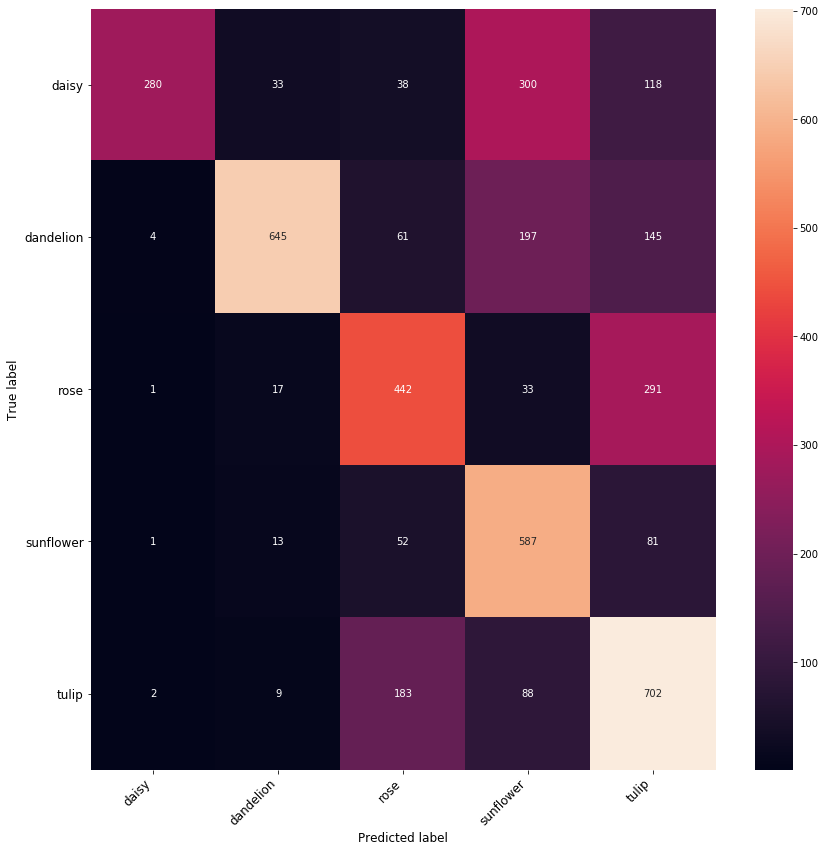

In [49]:
plot_confusion_matrix(conf, labels, figsize=(14, 14))

In [50]:
print(metrics.classification_report(target_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

       daisy       0.97      0.36      0.53       769
   dandelion       0.90      0.61      0.73      1052
        rose       0.57      0.56      0.57       784
   sunflower       0.49      0.80      0.61       734
       tulip       0.53      0.71      0.60       984

    accuracy                           0.61      4323
   macro avg       0.69      0.61      0.61      4323
weighted avg       0.70      0.61      0.61      4323



In [51]:
# Find for which images the predicted class is wrong
wrong_images = np.where(predicted_labels != target_labels)[0]

# For every prediction, find the largest probability value;
# this is the probability of the winning class for this image
probs_max = np.max(probabilities, axis=-1)

# Sort the probabilities from the wrong images from low to high
idx = np.argsort(probs_max[wrong_images])

# Reverse the order (high to low), and keep the 5 highest ones
idx = idx[::-1][:5]

# Get the indices of the images with the worst predictions
worst_predictions = wrong_images[idx]

index2class = {v:k for k,v in test_generator.class_indices.items()}

for i in worst_predictions:
    print("%s was predicted as '%s' %.4f\n" % (
        test_generator.filenames[i],
        index2class[predicted_labels[i]],
        probs_max[i]
    ))

sunflower/9231555352_d2dd8f8e68_m.jpg was predicted as 'rose' 0.9796

tulip/20876954720_62920b4ce8_n.jpg was predicted as 'rose' 0.9788

tulip/20093632966_0d53e13036_n.jpg was predicted as 'rose' 0.9769

tulip/133960364_d87f883c15_n.jpg was predicted as 'rose' 0.9741

daisy/18679421522_3be9879e32.jpg was predicted as 'rose' 0.9678



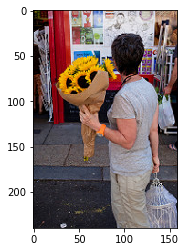

In [52]:
from keras.preprocessing import image
img = image.load_img(test_data_dir + test_generator.filenames[worst_predictions[0]])
plt.imshow(img)